In [1]:
import matplotlib as mpl
import pandas as pd
from pandas.plotting import parallel_coordinates

from utils import read_config
%matplotlib inline

Use token from .telepythrc.


In [2]:
colors = [c['color'] for c in mpl.rcParams['axes.prop_cycle']]

In [3]:
models = ['baseline', 'scaledsvd', 'hybridsvd', 'scaledhybridsvd', 'lce_rank', 'fm_rank', 'sgd_rank']
cs_models = ['baseline_coldstart', 'scaledsvd_coldstart', 'hybridsvd_coldstart', 'scaledhybridsvd_coldstart', 'lce_coldstart_rank', 'fm_coldstart_rank']
data_labels = ['ML1M', 'ML10M', 'BX', 'AMZvg', 'AMZe', 'YaMus']

# Standard case

In [36]:
for label in data_labels:
    print(label)
    for model in models:
        try:
            config = read_config(model, label)
        except FileNotFoundError:
            print(f'\t !No data for {model}')
        else:
            if 'scaledhybridsvd' in model:
                params =  read_config('scaledsvd', label)
                config['HybridSVDs'] = {**{k:v for k,v in params['PureSVDs'].items() if k=='col_scaling'},
                                        **config['HybridSVDs']}            
            if 'lce' in model:
                params = read_config('lce_param', label)
                config['LCE'] = {**{k:v for k,v in params['LCE'].items() if k in ['alpha', 'beta']}, **config['LCE']}
            if 'fm' in model:
                params = read_config('fm_param', label)
                config['FM'] = {**{k:v for k,v in params['FM'].items() if k.endswith('regularization')}, **config['FM']}
            if 'sgd' in model:
                params = read_config('sgd_param', label)
                config['SGD'] = {**{k:v for k,v in params['SGD'].items() if k.endswith('regularization')}, **config['SGD']}
            print('\t', config)

ML1M
	 {'PureSVD': {'rank': 30}}
	 {'PureSVDs': {'col_scaling': 0.4, 'rank': 75}}
	 {'HybridSVD': {'features_weight': 0.9, 'rank': 50}}
	 {'HybridSVDs': {'col_scaling': 0.4, 'features_weight': 0.7, 'rank': 100}}
	 {'LCE': {'alpha': 0.1, 'beta': 0.1, 'rank': 150}}
	 {'FM': {'regularization': 3e-08, 'linear_regularization': 1e-10, 'rank': 750}}
	 {'SGD': {'regularization': 3e-06, 'linear_regularization': 1e-10, 'rank': 1000}}
ML10M
	 {'PureSVD': {'rank': 30}}
	 {'PureSVDs': {'col_scaling': 0.2, 'rank': 1000}}
	 {'HybridSVD': {'features_weight': 0.1, 'rank': 30}}
	 {'HybridSVDs': {'col_scaling': 0.2, 'features_weight': 0.1, 'rank': 1000}}
	 {'LCE': {'alpha': 0.3, 'beta': 0.1, 'rank': 1000}}
	 {'FM': {'regularization': 1e-06, 'linear_regularization': 3e-07, 'rank': 750}}
	 {'SGD': {'regularization': 1e-06, 'linear_regularization': 1e-07, 'rank': 750}}
BX
	 {'PureSVD': {'rank': 1250}}
	 {'PureSVDs': {'col_scaling': 0.4, 'rank': 1000}}
	 {'HybridSVD': {'features_weight': 0.3, 'rank': 1250}}


## model rank comparison

In [6]:
ranks = []
for label in data_labels:
    for model in models:
        try:
            config = read_config(model, label)
        except FileNotFoundError:
            pass
        else:
            for name, params in config.items():
                ranks.append((name, label, params['rank']))

In [7]:
opt_config = pd.DataFrame(ranks, columns=['model', 'data', 'rank'])
opt_config.head()

,model,data,rank
0,PureSVD,ML1M,30
1,PureSVDs,ML1M,75
2,HybridSVD,ML1M,50
3,HybridSVDs,ML1M,100
4,LCE,ML1M,150


In [8]:
opt_config.set_index(['model','data']).sort_index().unstack('data').head()

rank                             
data        AMZe AMZvg    BX ML10M ML1M YaMus
model                                        
FM          1750  2000   750   750  750     1
HybridSVD   1500   150  1250    30   50  3000
HybridSVDs  3000   300  1750  1000  100  3000
LCE          100  2500  1500  1000  150  3000
PureSVD     1000   150  1250    30   30  3000

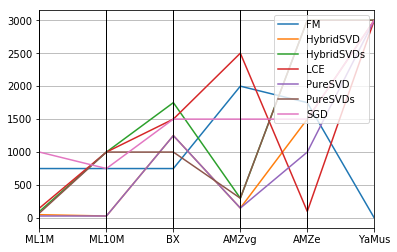

In [9]:
parallel_coordinates(opt_config.set_index(['model','data']).sort_index().unstack('data').loc[:, 'rank'].loc[:, data_labels].reset_index(),
                     'model', color=colors)

## svd hybridization

In [10]:
opt_svd_config = opt_config.loc[opt_config['model'].str.contains('SVD')]
opt_svd_config.head()

,model,data,rank
0,PureSVD,ML1M,30
1,PureSVDs,ML1M,75
2,HybridSVD,ML1M,50
3,HybridSVDs,ML1M,100
7,PureSVD,ML10M,30


In [11]:
opt_svd_config.set_index(['model','data']).sort_index().unstack('data').reset_index()

model  rank                             
data              AMZe AMZvg    BX ML10M ML1M YaMus
0      HybridSVD  1500   150  1250    30   50  3000
1     HybridSVDs  3000   300  1750  1000  100  3000
2        PureSVD  1000   150  1250    30   30  3000
3       PureSVDs  3000   300  1000  1000   75  3000

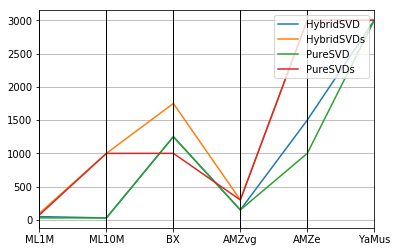

In [12]:
parallel_coordinates(opt_svd_config.set_index(['model','data']).sort_index().unstack('data').loc[:, 'rank'].loc[:, data_labels].reset_index(),
                     'model', color=colors)

## svd scaling

In [13]:
scaling = []
for label in data_labels:
    for model in models:
        try:
            config = read_config(model, label)
        except FileNotFoundError:
            pass
        else:
            for name, params in config.items():
                if name.endswith('SVD'):
                    scaling.append((name, False, label, params['rank']))
                if name.endswith('SVDs'):
                    scaling.append((name[:-1], True, label, params['rank']))

In [14]:
data = pd.DataFrame(scaling, columns=['model','scaling', 'data', 'rank'])
data.head()

,model,scaling,data,rank
0,PureSVD,False,ML1M,30
1,PureSVD,True,ML1M,75
2,HybridSVD,False,ML1M,50
3,HybridSVD,True,ML1M,100
4,PureSVD,False,ML10M,30


In [15]:
data.set_index(['model','scaling','data']).sort_index().unstack('data').head()

rank                             
data               AMZe AMZvg    BX ML10M ML1M YaMus
model     scaling                                   
HybridSVD False    1500   150  1250    30   50  3000
          True     3000   300  1750  1000  100  3000
PureSVD   False    1000   150  1250    30   30  3000
          True     3000   300  1000  1000   75  3000

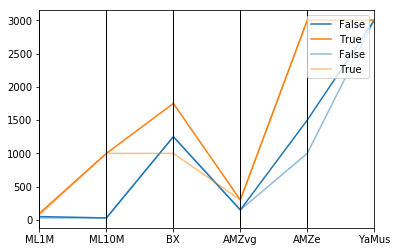

In [16]:
parallel_coordinates(data.set_index(['model','scaling','data']).sort_index().unstack('data').loc['HybridSVD', 'rank'].loc[:, data_labels].reset_index(),
                     'scaling', color=colors)
parallel_coordinates(data.set_index(['model','scaling','data']).sort_index().unstack('data').loc['PureSVD', 'rank'].loc[:, data_labels].reset_index(),
                     'scaling', color=colors, alpha=0.5)

In [17]:
data.set_index(['model','scaling','data']).sort_index().unstack('scaling').head()

rank      
scaling         False True 
model     data             
HybridSVD AMZe   1500  3000
          AMZvg   150   300
          BX     1250  1750
          ML10M    30  1000
          ML1M     50   100

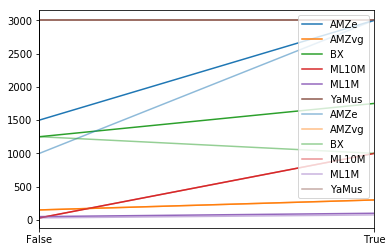

In [18]:
parallel_coordinates(data.set_index(['model','scaling','data']).sort_index().unstack('scaling').loc['HybridSVD', 'rank'].reset_index().dropna(),
                     'data', color=colors)
parallel_coordinates(data.set_index(['model','scaling','data']).sort_index().unstack('scaling').loc['PureSVD', 'rank'].reset_index().dropna(),
                     'data', color=colors, alpha=0.5)

In [19]:
data.set_index(['model','scaling','data']).sort_index().unstack('model')

rank        
model         HybridSVD PureSVD
scaling data                   
False   AMZe       1500    1000
        AMZvg       150     150
        BX         1250    1250
        ML10M        30      30
        ML1M         50      30
        YaMus      3000    3000
True    AMZe       3000    3000
        AMZvg       300     300
        BX         1750    1000
        ML10M      1000    1000
        ML1M        100      75
        YaMus      3000    3000

# Cold start

In [20]:
for label in data_labels:
    print(label + '(CS)')
    for model in cs_models:
        try:
            config = read_config(model, label)
        except FileNotFoundError:
            print(f'\t !No data for {model}')
        else:
            if 'lce' in model:
                params = read_config('lce_coldstart_param', label)
                config['LCE(cs)'] = {**{k:v for k,v in params['LCE(cs)'].items() if k in ['alpha', 'beta']},
                                     **config['LCE(cs)']}
            if 'fm' in model:
                params = read_config('fm_coldstart_param', label)
                config['FM(cs)'] = {**{k:v for k,v in params['FM(cs)'].items() if k.endswith('regularization')},
                                    **config['FM(cs)']}
            if 'scaledhybridsvd' in model:
                params =  read_config('scaledsvd_coldstart', label)
                config['HybridSVDs(cs)'] = {**{k:v for k,v in params['PureSVDs(cs)'].items() if k=='col_scaling'},
                                            **config['HybridSVDs(cs)']}
            print('\t', config)

ML1M(CS)
	 {'PureSVD(cs)': {'rank': 100}}
	 {'PureSVDs(cs)': {'col_scaling': 0.6, 'rank': 30}}
	 {'HybridSVD(cs)': {'features_weight': 0.7, 'rank': 5}}
	 {'HybridSVDs(cs)': {'col_scaling': 0.6, 'features_weight': 0.7, 'rank': 5}}
	 {'LCE(cs)': {'alpha': 0.9, 'beta': 0.0, 'rank': 1}}
	 {'FM(cs)': {'regularization': 1e-10, 'linear_regularization': 1e-06, 'rank': 5}}
ML10M(CS)
	 {'PureSVD(cs)': {'rank': 400}}
	 {'PureSVDs(cs)': {'col_scaling': 0.2, 'rank': 60}}
	 {'HybridSVD(cs)': {'features_weight': 0.9, 'rank': 60}}
	 {'HybridSVDs(cs)': {'col_scaling': 0.2, 'features_weight': 0.9, 'rank': 50}}
	 {'LCE(cs)': {'alpha': 0.3, 'beta': 0.0, 'rank': 15}}
	 {'FM(cs)': {'regularization': 3e-06, 'linear_regularization': 1e-06, 'rank': 75}}
BX(CS)
	 {'PureSVD(cs)': {'rank': 400}}
	 {'PureSVDs(cs)': {'col_scaling': 0.2, 'rank': 400}}
	 {'HybridSVD(cs)': {'features_weight': 0.9, 'rank': 750}}
	 {'HybridSVDs(cs)': {'col_scaling': 0.2, 'features_weight': 0.9, 'rank': 500}}
	 {'LCE(cs)': {'alpha': 0.1,

## model rank comparison

In [21]:
ranks = []
for label in data_labels:
    for model in cs_models:
        try:
            config = read_config(model, label)
        except FileNotFoundError:
            pass
        else:
            for name, params in config.items():
                ranks.append((name, label, params['rank']))

In [22]:
opt_config = pd.DataFrame(ranks, columns=['model', 'data', 'rank'])
opt_config.head()

,model,data,rank
0,PureSVD(cs),ML1M,100
1,PureSVDs(cs),ML1M,30
2,HybridSVD(cs),ML1M,5
3,HybridSVDs(cs),ML1M,5
4,LCE(cs),ML1M,1


In [23]:
opt_config.set_index(['model','data']).sort_index().unstack('data').head()

rank                                     
data              AMZe   AMZvg     BX  ML10M   ML1M   YaMus
model                                                      
FM(cs)          1000.0    50.0  150.0   75.0    5.0     NaN
HybridSVD(cs)   1750.0  2000.0  750.0   60.0    5.0  2500.0
HybridSVDs(cs)   750.0   500.0  500.0   50.0    5.0  2000.0
LCE(cs)         3000.0  2000.0   75.0   15.0    1.0   500.0
PureSVD(cs)     2500.0  3000.0  400.0  400.0  100.0  2000.0

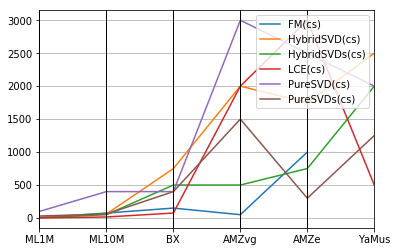

In [24]:
parallel_coordinates(opt_config.set_index(['model','data']).sort_index().unstack('data').loc[:, 'rank'].loc[:, data_labels].reset_index(),
                     'model', color=colors)

## svd hybridization

In [25]:
opt_svd_config = opt_config.loc[opt_config['model'].str.contains('SVD')]
opt_svd_config.head()

,model,data,rank
0,PureSVD(cs),ML1M,100
1,PureSVDs(cs),ML1M,30
2,HybridSVD(cs),ML1M,5
3,HybridSVDs(cs),ML1M,5
6,PureSVD(cs),ML10M,400


In [26]:
opt_svd_config.set_index(['model','data']).sort_index().unstack('data').reset_index()

model  rank                            
data                  AMZe AMZvg   BX ML10M ML1M YaMus
0      HybridSVD(cs)  1750  2000  750    60    5  2500
1     HybridSVDs(cs)   750   500  500    50    5  2000
2        PureSVD(cs)  2500  3000  400   400  100  2000
3       PureSVDs(cs)   300  1500  400    60   30  1250

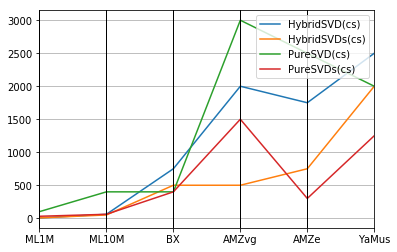

In [27]:
parallel_coordinates(opt_svd_config.set_index(['model','data']).sort_index().unstack('data').loc[:, 'rank'].loc[:, data_labels].reset_index(),
                     'model', color=colors)

## svd scaling

In [28]:
scaling = []
for label in data_labels:
    for model in cs_models:
        try:
            config = read_config(model, label)
        except FileNotFoundError:
            pass
        else:
            for name, params in config.items():
                if name.endswith('SVD(cs)'):
                    scaling.append((name, False, label, params['rank']))
                if name.endswith('SVDs(cs)'):
                    scaling.append((name[:-5]+'(cs)', True, label, params['rank']))

In [29]:
data = pd.DataFrame(scaling, columns=['model','scaling', 'data', 'rank'])
data.head()

,model,scaling,data,rank
0,PureSVD(cs),False,ML1M,100
1,PureSVD(cs),True,ML1M,30
2,HybridSVD(cs),False,ML1M,5
3,HybridSVD(cs),True,ML1M,5
4,PureSVD(cs),False,ML10M,400


In [30]:
from pandas.plotting import parallel_coordinates

In [31]:
data.set_index(['model','scaling','data']).sort_index().unstack('data').head()

rank                            
data                   AMZe AMZvg   BX ML10M ML1M YaMus
model         scaling                                  
HybridSVD(cs) False    1750  2000  750    60    5  2500
              True      750   500  500    50    5  2000
PureSVD(cs)   False    2500  3000  400   400  100  2000
              True      300  1500  400    60   30  1250

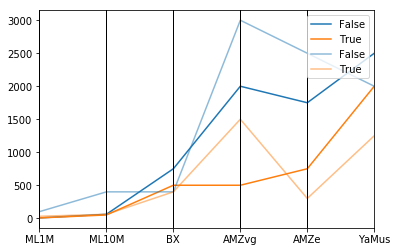

In [32]:
parallel_coordinates(data.set_index(['model','scaling','data']).sort_index().unstack('data').loc['HybridSVD(cs)', 'rank'].loc[:, data_labels].reset_index(),
                     'scaling', color=colors)
parallel_coordinates(data.set_index(['model','scaling','data']).sort_index().unstack('data').loc['PureSVD(cs)', 'rank'].loc[:, data_labels].reset_index(),
                     'scaling', color=colors, alpha=0.5)

In [33]:
data.set_index(['model','scaling','data']).sort_index().unstack('scaling').head()

rank      
scaling             False True 
model         data             
HybridSVD(cs) AMZe   1750   750
              AMZvg  2000   500
              BX      750   500
              ML10M    60    50
              ML1M      5     5

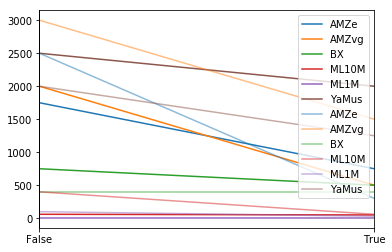

In [34]:
parallel_coordinates(data.set_index(['model','scaling','data']).sort_index().unstack('scaling').loc['HybridSVD(cs)', 'rank'].reset_index().dropna(),
                     'data', color=colors)
parallel_coordinates(data.set_index(['model','scaling','data']).sort_index().unstack('scaling').loc['PureSVD(cs)', 'rank'].reset_index().dropna(),
                     'data', color=colors, alpha=0.5)

In [35]:
data.set_index(['model','scaling','data']).sort_index().unstack('model').head()

rank            
model         HybridSVD(cs) PureSVD(cs)
scaling data                           
False   AMZe           1750        2500
        AMZvg          2000        3000
        BX              750         400
        ML10M            60         400
        ML1M              5         100